# Problema

En este notebook trabajaremos con una base de datos de 2000 tweets que están compuestos por mensajes escritos en "Spanglish" (partes en inglés, partes en español). Cada 'Tweet' se encuentra etiquetado con una de tres categorías: Positivo, Negativo, Neutro, para referirse al sentimiento del contenido. Además, las palabras de cada mensaje se encuentras etiquetadas como inglés, español u alguna otro tipo de etiqueta.

( Para mas información: https://ritual-uh.github.io/sentimix2020/)

# Dependencias

In [1]:
import pandas as pd
import numpy as np
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
stopwords.words('spanish')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/Curso-WorkingAnalyst/semana2/'

# Carga de los datos

In [6]:
data_raw = pd.read_csv(path + 'spanglish_trial.txt', sep='\t', header=None, comment='"', encoding='utf-8-sig')

In [7]:
aux = data_raw[data_raw[0] == 'meta']

data = pd.DataFrame()

for key, value in enumerate(aux.index):
    a_row = pd.DataFrame(0, index=[0], columns=['#_Tweet', 'Sentimiento', 'Texto', 'lang1', 'lang2'])
    if key == 1999:
        batch = data_raw.loc[value:len(data_raw)-1, :]
    else:
        batch = data_raw.iloc[value:aux.index[key+1], :]

    a_row['#_Tweet'] = batch.iloc[0, 1]
    a_row['Sentimiento'] = batch.iloc[0, 2]
    texto = ''
    for i in range(1, len(batch)):
        texto = texto + batch.iloc[i, 0] + ' '
    texto = texto.strip()
    a_row['Texto'] = texto

    aux1 = batch[batch[1] == 'lang1']
    texto = ''
    for i in range(0, len(aux1)):
        texto = texto + aux1.iloc[i, 0] + ' '
    texto = texto.strip()
    a_row['lang1'] = texto

    aux2 = batch[batch[1] == 'lang2']
    texto = ''
    for i in range(0, len(aux2)):
        texto = texto + aux2.iloc[i, 0] + ' '
    texto = texto.strip()
    a_row['lang2'] = texto

    data = pd.concat([data, a_row])

data.reset_index(inplace=True, drop=True)

In [9]:
# Limpiar tweets "neutrales"
data = data[data['Sentimiento'] != 'neutral']

In [10]:
data

,#_Tweet,Sentimiento,Texto,lang1,lang2
0,1,positive,So that means tomorrow cruda segura lol,So that means tomorrow lol,cruda segura
2,3,negative,Eres tan mala vieja bruja interesada #jamming,#jamming,Eres tan mala vieja bruja interesada
4,5,negative,Fuck that ni ke el me vaya a mantener toda la ...,Fuck that lol,ni ke el me vaya a mantener toda la vida
5,6,negative,I always tell my dad ke me kiero kasar con una...,I always tell my dad and telling me,ke me kiero kasar con una vieja rika me regaña...
8,9,negative,Since I started working ya ni disfruto la vida...,Since I started working lol,ya ni disfruto la vida
...,...,...,...,...,...
1994,1995,positive,"@Izzy_teee lol allbaad ni te dejas ver lol , y...",lol allbaad lol you only got one class,ni te dejas ver
1996,1997,positive,@stahrlove hahaa Fuhk you to te doy algo pa qu...,hahaa Fuhk you to,te doy algo pa que jales cabrona
1997,1998,positive,@Yaritzaa__ yo pierdo peso y ni si quiera esto...,lmao I 've been getting tone lol I love waking...,yo pierdo peso y ni si quiera estoy de dieta
1998,1999,positive,@EliZaIBQ Please pay attention . Can I get you...,Please pay attention Can I get your attention ...,presta atencion Puedo tener tu atencion


# Funciones auxiliares para procesamiento de texto

In [11]:
def remover_stopwords(text, lang):
    stop = re.compile(r'\b(' + r'|'.join(stopwords.words(lang)) + r')\b\s*')
    nuevo_texto = stop.sub('', text)
    return nuevo_texto

In [12]:
def elimina_puntuacion_y_numeros(text):
    nuevo_texto = re.sub('[^a-z]+', ' ', text)
    return nuevo_texto

In [13]:
# Solo para inglés
def lematizar(text):
    lemma = WordNetLemmatizer()
    text = text.split()
    nuevo_texto = " ".join([lemma.lemmatize(i) for i in text])
    return nuevo_texto

In [14]:
def stemmer(text, lang):
    st = SnowballStemmer(lang)
    text = text.split()
    nuevo_texto = ' '.join([st.stem(k) for k in text])
    return nuevo_texto

In [15]:
def preprocesar(text, lang):
    text = text.lower()
    text = remover_stopwords(text, lang)
    text = elimina_puntuacion_y_numeros(text)
    text = stemmer(text, lang)
    return text

**¿Qué acción realizan las funciones?**

Veamos con un ejemplo.

In [ ]:
eg_string = 'Lemmatization is the process of converting a word to its base form. The difference between stemming and lemmatization is, ' \
            'lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the ' \
            'last few characters, often leading to incorrect meanings and spelling errors.'

In [ ]:
remover_stopwords(eg_string, 'english')

In [ ]:
elimina_puntuacion_y_numeros(eg_string.lower())

In [ ]:
stemmer(eg_string, 'spanish')

In [ ]:
lematizar(eg_string)

¿Porque lematizar o stemizar?

In [ ]:
lematizar(remover_stopwords('my feet foot', 'english'))

In [ ]:
stemmer(remover_stopwords('my feet foot', 'english'), 'english')

Exploremos nuestros datos

In [16]:
data.Sentimiento.value_counts()

positive    763
negative    535
Name: Sentimiento, dtype: int64

Preoprocecemos nuestros datos

In [17]:
data['lang1_pp'] = data['lang1'].apply(lambda x: preprocesar(x, 'english'))
data['lang2_pp'] = data['lang2'].apply(lambda x: preprocesar(x, 'spanish'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
data['Sentimiento'] = data['Sentimiento'].apply(lambda x: 0 if x=='negative' else 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
data.head()

,#_Tweet,Sentimiento,Texto,lang1,lang2,lang1_pp,lang2_pp
0,1,1,So that means tomorrow cruda segura lol,So that means tomorrow lol,cruda segura,mean tomorrow lol,crud segur
2,3,0,Eres tan mala vieja bruja interesada #jamming,#jamming,Eres tan mala vieja bruja interesada,jam,tan mal viej bruj interes
4,5,0,Fuck that ni ke el me vaya a mantener toda la ...,Fuck that lol,ni ke el me vaya a mantener toda la vida,fuck lol,ke vay manten tod vid
5,6,0,I always tell my dad ke me kiero kasar con una...,I always tell my dad and telling me,ke me kiero kasar con una vieja rika me regaña...,alway tell dad tell,ke kier kas viej rik reg a ke interes
8,9,0,Since I started working ya ni disfruto la vida...,Since I started working lol,ya ni disfruto la vida,sinc start work lol,disfrut vid


**Representación gráfica para darnos una mejor idea**

In [20]:
def nube_palabras(sec_textos):
    # Crear la cadena con la que haremos la nube de palabras
    text = " ".join(review for review in sec_textos)

    # Crear la nube de palabras
    wordcloud = WordCloud(max_font_size=50,
                          max_words=100,
                          background_color="white").generate(text)

    # Mostrar nuestro gráfico
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

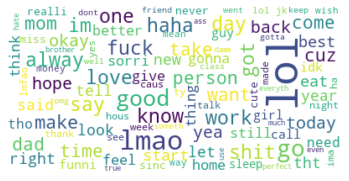

In [21]:
nube_palabras(data['lang1_pp'])

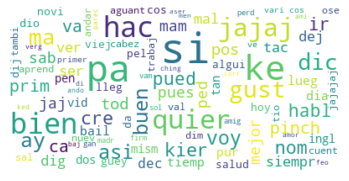

In [22]:
nube_palabras(data['lang2_pp'])

Si quisieramos ver las nubes de palabras centrandonos mas en el idioma o el sentimiento a analizar

In [23]:
porClase = data.groupby('Sentimiento')
positivas = porClase.get_group(1).lang1_pp
negativas = porClase.get_group(0).lang1_pp

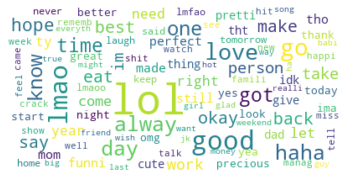

In [24]:
nube_palabras(positivas)

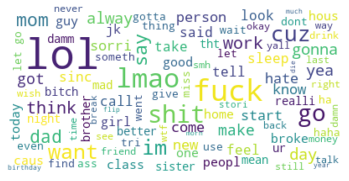

In [25]:
nube_palabras(negativas)

In [26]:
positivas_es = porClase.get_group(1).lang2_pp
negativas_es = porClase.get_group(0).lang2_pp

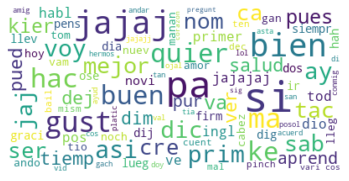

In [27]:
nube_palabras(positivas_es)

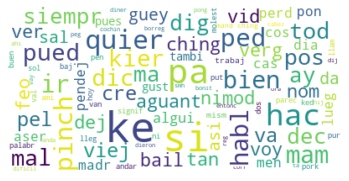

In [28]:
nube_palabras(negativas_es)

Bolsa de Palabras: Nuestro modo de asignar un vector numérico a nuestras cadenas de caractéres

In [29]:
# BOW: Bag Of Words
vectorizer = TfidfVectorizer(min_df=2)
BOW_en = vectorizer.fit_transform(data['lang1_pp'])
BOW_en.shape

(1298, 642)

In [30]:
palabras = vectorizer.get_feature_names_out()
X_en = pd.DataFrame(BOW_en.todense(), index=data.index, columns=palabras)
X_en

,abl,absolut,abt,act,actual,af,age,ago,ah,ahead,...,yall,yea,yeah,year,yes,yess,yesss,yo,your,yuck
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# dataframe.reset_index(inplace=True, drop=True)
X_en['mean']

0       0.658021
2       0.000000
4       0.000000
5       0.000000
8       0.000000
          ...   
1994    0.000000
1996    0.000000
1997    0.000000
1998    0.000000
1999    0.000000
Name: mean, Length: 1298, dtype: float64

In [32]:
vectorizer2 = TfidfVectorizer(min_df=2)
BOW_es = vectorizer2.fit_transform(data['lang2_pp'])
BOW_es.shape

(1298, 570)

In [33]:
palabras_es = vectorizer2.get_feature_names_out()
X_es = pd.DataFrame(BOW_es.todense(), index=data.index, columns=palabras_es)
X_es

,abland,ablas,abuel,acab,acav,acept,acord,acuerd,ada,adicion,...,vien,vin,vist,viv,volv,voy,wee,wey,xqu,zapat
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# data.loc[1999, : ]
data.iloc[1297, : ]

#_Tweet                                                     2000
Sentimiento                                                    1
Texto          @EliZaIBQ cierto ? Keep track , q es la forma ...
lang1                           Keep track keep up the good work
lang2          cierto q es la forma más exacta no se viene a ...
lang1_pp                               keep track keep good work
lang2_pp                      ciert q form exact vien cabez habl
Name: 1999, dtype: object

In [43]:
# Así sería la data de entrenamiento de nuestro modelo
X = pd.concat([X_en, X_es], axis=1)

y = data['Sentimiento']

In [44]:
y

0       1
2       0
4       0
5       0
8       0
       ..
1994    1
1996    1
1997    1
1998    1
1999    1
Name: Sentimiento, Length: 1298, dtype: int64

In [45]:
# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [47]:
X_test.shape

(260, 1212)

In [48]:
clasificador = LogisticRegression(penalty= 'none', random_state=42)
clf = clasificador.fit(X_train, y_train)

clf.score(X_test, y_test)

0.6576923076923077

In [49]:
def evaluación(modelo, conjunto):
    mensaje_error = 'conjunto solo puede ser "entrenamiento" o "prueba"'
    assert conjunto in ['entrenamiento', 'prueba'], mensaje_error

    if conjunto == 'entrenamiento':
        X = X_train
        y = y_train
    else:
        X = X_test
        y = y_test

    y_pred = modelo.predict(X)
    precision = accuracy_score(y, y_pred) * 100

    # creamos un diccionario con las etiquetas
    data = {'y_Real': y,
            'y_Prediccion': y_pred
            }
    # lo convertimos en un DataFrame de pandas
    df = pd.DataFrame(data, columns=['y_Real', 'y_Prediccion'])

    # hacemos una tabla crusada para obtener la matriz de confusión
    confusion_matrix = pd.crosstab(df['y_Real'], df['y_Prediccion'],
                                   rownames=['Real'], colnames=['Predicción'])

    # realizamos un mapa de calor
    titulo = 'Datos:{}, precisión = {:4.2f}'.format(conjunto, precision)
    sns.heatmap(confusion_matrix, annot=True, fmt='g').set(title=titulo)
    plt.show()

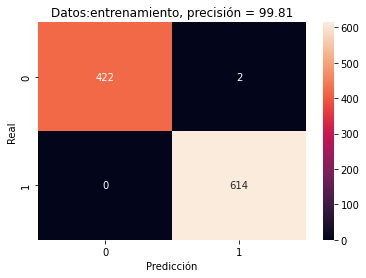

In [50]:
evaluación(clf, 'entrenamiento')

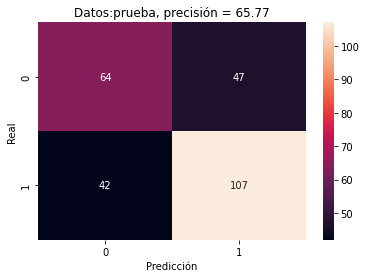

In [51]:
evaluación(clf, 'prueba')

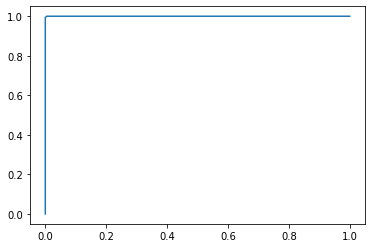

AUC Score Train:  0.9999846352406121

--------------------------------------------------


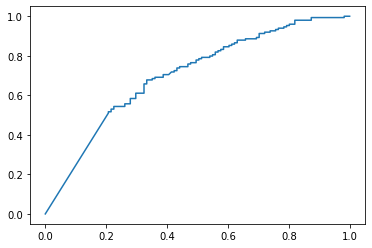

AUC Score Test:  0.7036701130660863


In [52]:
y_pred_prob_train = clf.predict_proba(X_train)[::, 1]
fpr, tpr, _ = roc_curve(y_train, y_pred_prob_train)
auc = roc_auc_score(y_train, y_pred_prob_train)

plt.plot(fpr, tpr)
plt.show()

print("AUC Score Train: ", auc)

print()
print('-----'*10)
y_pred_prob_test = clf.predict_proba(X_test)[::, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_test)
auc = roc_auc_score(y_test, y_pred_prob_test)

plt.plot(fpr, tpr)
plt.show()

print("AUC Score Test: ", auc)

# Regresión penalizada (Regresión Ridge)

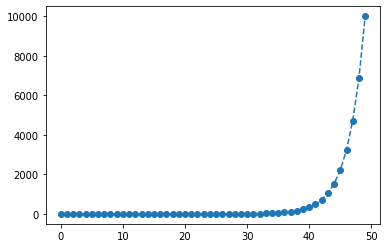

In [53]:
lambdas = np.logspace(-4, 4, 50)
plt.plot(lambdas, linestyle='--', marker='o')
plt.show()

In [54]:
lambdas

array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-02, 8.68511374e-02, 1.26485522e-01,
       1.84206997e-01, 2.68269580e-01, 3.90693994e-01, 5.68986603e-01,
       8.28642773e-01, 1.20679264e+00, 1.75751062e+00, 2.55954792e+00,
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04])

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(LogisticRegression(penalty='l2', max_iter=500), {'C': 1/lambdas}, cv=5, return_train_score=False)
grid_search.fit(X, y)

# Resultado
# C = 2.5595479226995383

In [ ]:
# Obtiene el mejor parametro C para mi regresión
grid_search.best_params_

In [55]:
C = 2.5595479226995383

In [56]:
clasificador_ridge = LogisticRegression(penalty= 'l2', C = C, random_state=42)
clf_ridge = clasificador_ridge.fit(X_train, y_train)

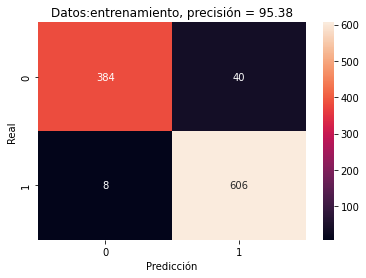

In [57]:
evaluación(clasificador_ridge, 'entrenamiento')

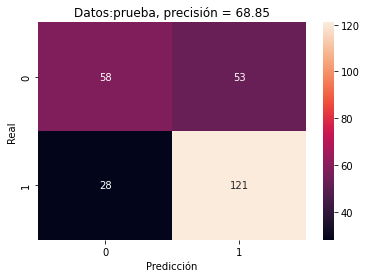

In [58]:
evaluación(clasificador_ridge, 'prueba')

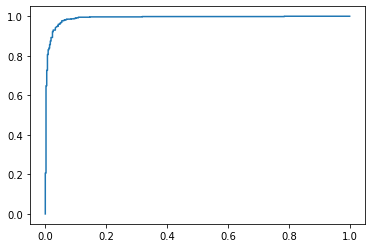

AUC Score Train:  0.9903624546739597

--------------------------------------------------


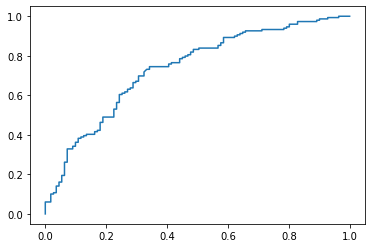

AUC Score Test:  0.7361388233871455


In [59]:
y_pred_prob_train = clf_ridge.predict_proba(X_train)[::, 1]
fpr, tpr, _ = roc_curve(y_train, y_pred_prob_train)
auc = roc_auc_score(y_train, y_pred_prob_train)

plt.plot(fpr, tpr)
plt.show()

print("AUC Score Train: ", auc)

print()
print('-----'*10)
y_pred_prob_test = clf_ridge.predict_proba(X_test)[::, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_test)
auc = roc_auc_score(y_test, y_pred_prob_test)

plt.plot(fpr, tpr)
plt.show()

print("AUC Score Test: ", auc)

# Jugando con probabilidades de clasificación

Para la regresion logística

In [65]:
resultados = {'P(negativa)' : clf.predict_proba(X_test)[:,0],
              'P(positiva)' : clf.predict_proba(X_test)[:,1],
              'y_pred_50' : clf.predict(X_test),
              }

predicciones = pd.DataFrame(resultados)

In [66]:
predicciones

,P(negativa),P(positiva),y_pred_50
0,0.999216,7.835405e-04,0
1,0.026792,9.732082e-01,1
2,1.000000,1.520198e-13,0
3,0.333320,6.666799e-01,1
4,1.000000,2.160054e-43,0
...,...,...,...
255,0.000000,1.000000e+00,1
256,0.000245,9.997546e-01,1
257,0.000000,1.000000e+00,1
258,1.000000,8.842741e-20,0


In [67]:
predicciones.sort_values('P(negativa)',
                         ascending=False).iloc[100:115]

,P(negativa),P(positiva),y_pred_50
0,0.999216,0.000784,0
210,0.998697,0.001303,0
43,0.998581,0.001419,0
159,0.997290,0.002710,0
165,0.983144,0.016856,0
212,0.894006,0.105994,0
138,0.370458,0.629542,1
55,0.333320,0.666680,1
3,0.333320,0.666680,1
52,0.333320,0.666680,1


In [68]:
predicciones['y_pred_30'] = np.where( predicciones['P(negativa)'] > .3, '0', '1')
predicciones.sort_values('P(negativa)',
                         ascending=False).iloc[100:115]

,P(negativa),P(positiva),y_pred_50,y_pred_30
0,0.999216,0.000784,0,0
210,0.998697,0.001303,0,0
43,0.998581,0.001419,0,0
159,0.997290,0.002710,0,0
165,0.983144,0.016856,0,0
212,0.894006,0.105994,0,0
138,0.370458,0.629542,1,0
55,0.333320,0.666680,1,0
3,0.333320,0.666680,1,0
52,0.333320,0.666680,1,0


Coeficientes del modelo

In [69]:
coeficientes_rl = pd.Series(clf.coef_[0],
                            index= np.concatenate((palabras, palabras_es)),
                            name='Sin regularización').sort_values(ascending=False)
coeficientes_rl

love       224.921473
tac        178.348382
best       151.999059
emocion    151.175395
danc       147.649865
              ...    
suck      -153.839692
broke     -154.604711
cuz       -157.805785
ching     -181.257572
mind      -209.018190
Name: Sin regularización, Length: 1212, dtype: float64

In [70]:
coeficientes_ridge = pd.Series(clasificador_ridge.coef_[0],
                               index=np.concatenate((palabras, palabras_es)),
                               name='Ridge').sort_values(ascending=False)
coeficientes_ridge

love        2.461257
best        1.908143
tomorrow    1.812809
tac         1.808961
hope        1.663721
              ...   
wtf        -1.722441
think      -1.742724
cuz        -1.892227
ching      -1.960910
fuck       -2.524293
Name: Ridge, Length: 1212, dtype: float64

In [ ]:
np.exp(coeficientes_ridge)